# Classification Model

# Dataset - CIFAR10

DOWNLOAD DATA FROM [HERE](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) AND PUT IT TO THE DATA FOLDER

The [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks. Such a situation is called **multiclass** classification in oppose to **multilabel** classification when each example may have multiple label.

We can see the results [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

In [1]:
import _pickle as cPickle
import tarfile

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

# Data

Unarchive data

In [3]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
tar = tarfile.open("data/cifar-10-python.tar.gz", "r:gz")
tar.extractall("data")
tar.close()

## Reading

Data are stored as a memory dump with python $\text{dict}$ object. It was created using **pickle** function. To read one should "unpickle" it.

In [5]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding="latin1")
    fo.close()
    return dict

Data are also splitted in to 5 pieces for conveniece. Let's read them all and concatenate

In [54]:
for b in range(1, 6):
    data_batch = unpickle("data/cifar-10-batches-py/data_batch_" + str(b))
    if b == 1:
        X_train = data_batch["data"]
        y_train = np.array(data_batch["labels"])
    else:
        X_train = np.append(X_train, data_batch["data"], axis=0)
        y_train = np.append(y_train, data_batch["labels"], axis=0)

Read test data. In this dataset train/test split is provided by authors of the dataset to be able to consistently evaluate solutions

In [55]:
data_batch = unpickle("data/cifar-10-batches-py/test_batch")
X_test = data_batch["data"]
y_test = np.array(data_batch["labels"])

Read meta-information file with the names of the classes

In [56]:
classes = unpickle("data/cifar-10-batches-py/batches.meta")["label_names"]

## Pre-processing

We have too many data

In [85]:
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (5000, 3072)
Test size: (1000, 3072)


Let's take only 10% of them to train faster

In [58]:
subsample_rate = 0.1

We want to preserve the same quantity ratio between classes. In python such an option is called **stratification**. Let's randomly (with fixed initial seed for the sake of reproducibility) divide part of train data

In [59]:
X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=subsample_rate, random_state=42)

The same for test

In [60]:
X_test, _, y_test, _ = train_test_split(X_test, y_test, stratify=y_test, train_size=subsample_rate, random_state=42)

Indeed, we preserved the number of objects of each class

In [17]:
unique_train = np.unique(y_train, return_counts=True)
list(zip(np.array(classes)[unique_train[0]], unique_train[1]))

[('airplane', 50),
 ('automobile', 50),
 ('bird', 50),
 ('cat', 50),
 ('deer', 50),
 ('dog', 50),
 ('frog', 50),
 ('horse', 50),
 ('ship', 50),
 ('truck', 50)]

## Visualization

For now each object has the following shape

In [107]:
X_train[0].shape

(3072,)

$3072 = 32 \times 32 \times 3$ where $32 \times 32$ is the size of the image in pixels and $3$ is the number of channels (RGB)

To show this array as an image let's reshape it in the needed from with the shape $(32, 32, 1)$

In [108]:
def show_pic(x):
    plt.imshow(x.reshape((3, 32, 32)).transpose(1, 2, 0).astype("uint8"))
    plt.axis("off")

Draw one pic from each class

In [109]:
classes_idx_examples = np.zeros(10, dtype=np.int)
for i in range(10):
    classes_idx_examples[i] = np.where(y_train == i)[0][0]

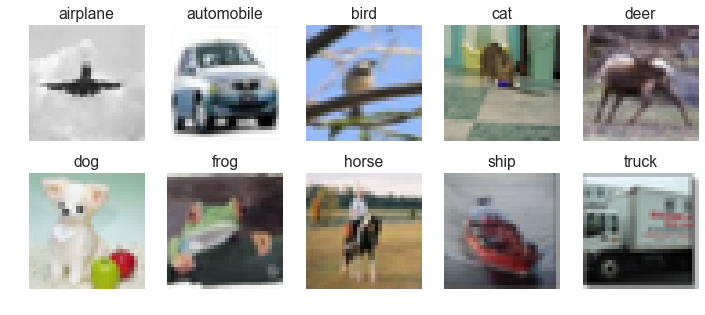

In [110]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(X_train[classes_idx_examples[i]])
    plt.title(classes[i])

# Sklearn Logistic Regression

Let's use Sklearn implementation of algorithms to have a benchmark.

Also one should **always** track the results of the experiments to be able to compare different approaches. Let's create pandas $\text{DataFrame}$ for this purpose.

In [111]:
results = pd.DataFrame(columns=["Model", "Test Accuracy"])

For now it is empty, but will be filled in later

In [112]:
results

,Model,Test Accuracy


## Defining model

Let's try Multinomial Logistic Regression (see theory in lectures)
Sklearn implementation of LogRegression implies mandatory usage of regularization (it almost always works better with it preventing overfitting). We want to explore very basic LogRegression model thus to "disable" regularization we need to reduce its impact to almost zero. It can be done by setting regularization constant $\lambda$ to very small value (in sklearn we define inverse regularization constant $C = 1 / \lambda$ thus we need to make it big)

Here we use Sklearn $\text{LogisticRegression}$ with few options:
* $\text{multi_class} = \text{"multinomial"} -$we want to build softmax classifier (there are other ways of dealing with multiclass setting for Logistic Regression)
* $\text{C} = 10^6-$ for now we don't want to use regularization; $\text{C}$ is the inverse regularization constant which is $\text{C} = \frac{1}{\lambda}$; thus we should make $\text{C}$ big to turn off regulazrization
* $\text{solver} = \text{sag} -$ optimization algorithm to use; Stochastic Average Gradient. Stochastic Gradient Descent method gitters massively. This is due to the not very good approximation of gradient (only by one example). To neglect this error one can simply average gradient across last few steps; that is exectly what $\text{sag}$ does
* $\text{max_iter} = 15 -$ the number of passes over the training data (aka epochs)

In [113]:
model_lr_sklearn = LogisticRegression(multi_class="multinomial", C=1e6, solver="sag", max_iter=15)

### Fitting

In [114]:
model_lr_sklearn.fit(X_train, y_train)

C:\Users\Devi\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=15,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False)

### Evaluation

Prediction

In [115]:
y_pred_test = model_lr_sklearn.predict(X_test)

Accuracy

In [116]:
acc = accuracy_score(y_test, y_pred_test)

Keeping table of results up-to-date

In [117]:
results.loc[len(results)] = ["LR Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,LR Sklearn,0.357


Keeping table of results up-to-date

# Dataset - Pima Diabetest - The Great Race

## BG: Part 1: Pima Diabetes classification

It is important to compare the performance of multiple different machine learning algorithms
consistently. We can use this test harness as a template on our own machine learning problems and add more and different
algorithms to compare. 

Activities to accompolish:
1. How to formulate an experiment to directly compare machine learning algorithms.
2. A reusable template for evaluating the performance of multiple algorithms on one dataset.
3. How to report and visualize the results when comparing algorithm performance.

In the example below six different classification
algorithms are compared on a single dataset:

*  Logistic Regression
*  Linear Discriminant Analysis
*  k-Nearest Neighbors
*  Classification and Regression Trees
*  Naive Bayes
*  Support Vector Machines.

The dataset is the Pima Indians onset of diabetes problem. The problem has two classes and
eight numeric input variables of varying scales. The 10-fold cross-validation procedure is used to
evaluate each algorithm, importantly configured with the same random seed to ensure that the
same splits to the training data are performed and that each algorithm is evaluated in precisely
the same way. Each algorithm is given a short name, useful for summarizing results afterward.

### Cross-Validation

The common method to evaluate the model is cross-validation. The idea behind it is to divide the whole set of objects into $k$ sections and then use one section as a test set and other $k-1$ as a train (repeat it with all the sections).

There is a special function for this in sklearn called $\text{KFold}$. It creates set of indices for cross-validation.

In [67]:
#e.g., 
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

Next step is to do everything that we've done before in a loop:
* Split
* Train
* Evaluate

And store the average value of the accuracy. Running the code below provides a list of each "algorithm short name", the mean accuracy and the standard deviation accuracy.

LR: 0.769515 (0.048411)
LDA: 0.773462 (0.051592)
KNN: 0.726555 (0.061821)
CART: 0.684774 (0.065611)
NB: 0.755178 (0.042766)
SVM: 0.651025 (0.072141)


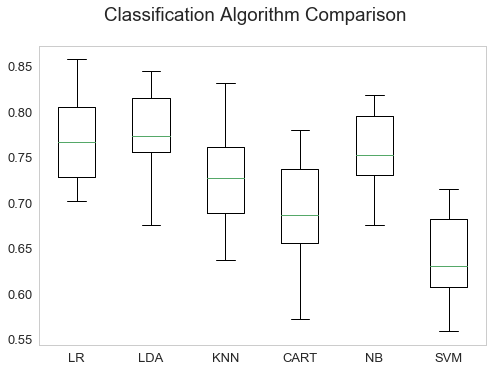

In [68]:
# Compare Algorithms
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
filename = 'pima-indians-diabetes.data.csv'
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(filename, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Classification Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.grid()
pyplot.show()


Above we produced a box and whisker plot showing the spread of the accuracy scores
across each cross-validation fold for each algorithm.

From these results, it would suggest that both logistic regression and linear discriminant
analysis are perhaps worthy of further study on this problem.

## CIFAR10 Great Race 
Repeat the above RACE for the CIFAR10 dataset and draw some conclusions

LR: 0.224000 (0.016273)


C:\Users\Devi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\Devi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\Devi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


LDA: 0.176200 (0.016086)
KNN: 0.274600 (0.011526)
CART: 0.216800 (0.020673)
NB: 0.293200 (0.019904)
SVM: 0.079200 (0.006145)


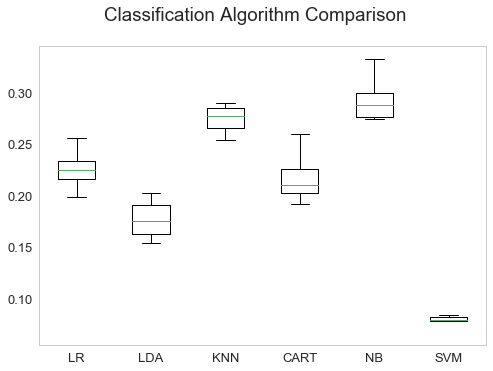

In [118]:
# New code to cross validate different alogrithms using CIFAR10 dataset
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
#filename = 'pima-indians-diabetes.data.csv'
#names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
#dataframe = read_csv(filename, names=names)
#array = dataframe.values
#X = array[:,0:8]
#Y = array[:,8]
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Classification Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.grid()
pyplot.show()

# Background: HyperParameter tuning on steroids

Machine learning models are parameterized so that their behavior can be tuned for a given problem. Models can have many parameters and finding the best combination of parameters can be treated as a search problem. In this section you will discover how to tune the parameters of machine learning algorithms in Python using the scikit-learn.

Grid search is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. You can perform a grid search using the GridSearchCV class1. 
In this section we will focus on setting up a pipeline for text classifiction, though it can be adapted to any machine learning problem.

## Pima Indian Grid search
The example below evaluates different alpha values for the Ridge Regression/LASSO algorithm on the Pima Diabetes binary classifiction data. This is a one-dimensional grid search.


In [70]:
# Grid Search for Algorithm Tuning
import numpy
from pandas import read_csv
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
filename = 'pima-indians-diabetes.data.csv'
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(filename, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
alphas = numpy.array([1,0.1,0.01,0.001,0.0001,0])
param_grid = dict(alpha=alphas)
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X, Y)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.279617559313
1.0


# Explore LASSO Logistic Regression On CIFAR-10 dataset
Model the CIFAR-10 dataset using LASSO Logistic Regression (l1 penalty term). Explore different values $\text{C}$ is the inverse regularization constant which is $\text{C} = \frac{1}{\lambda}$ that are listed here : {C=1.0, C=10.0, C=100.0, C=1000.0, C=10000.0}

We will add the reports of our experimental results using the `results` table. Add one more column for reporting the number of zero coefficients after training. Recall, LASSO Logistic Regression can be useful in doing feature selection!   

NOTE: the coefficient of the learnt model, `model_lr_sklearn`, are available via `model_lr_sklearn.coef_`

`coef_ : array, shape (1, n_features) or (n_classes, n_features)

Coefficient of the features in the decision function.

coef_ is of shape (1, n_features) when the given problem is binary.`

 

In [62]:
#************* LASSO Logistic Regression for different C values*******************************
# Logistic Regression
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from time import time

results = pd.DataFrame(columns=["Model Description", "Value of C", "Test Accuracy", "#of Zero Coefficients(Avg)"])

C = [1.0, 10.0, 100.0, 1000.0, 10000.0]

for c in C:
    logreg = LogisticRegression(penalty="l1", C=c)
    t = time()
    print('Fitting & Predicting for C=', c)
    logreg.fit(X_train, y_train)
    print("Fitted in %0.3fs" % (time() - t))
    
    t1 = time()
    predicted = logreg.predict(X_test)
    print("Predicted in %0.3fs" % (time() - t1))
    print("--------------------------")   
    
    #calculate average of zero coefficients for all 10 classes
    n = logreg.coef_.shape[0] * logreg.coef_.shape[1]
    zerocoeff = n - len(np.flatnonzero(logreg.coef_))
    avgzerocoeff = zerocoeff / n
    
    #calculate accuracy
    acc_c = np.round(accuracy_score(y_test, predicted), 3)
    
    results.loc[len(results)] = ["LR Sklearn real run", c, acc_c, avgzerocoeff]
print(results)

Fitting & Predicting for C= 1.0
Fitted in 4981.425s
Predicted in 0.041s
--------------------------
Fitting & Predicting for C= 10.0
Fitted in 4643.303s
Predicted in 0.143s
--------------------------
Fitting & Predicting for C= 100.0
Fitted in 4555.419s
Predicted in 0.114s
--------------------------
Fitting & Predicting for C= 1000.0
Fitted in 4537.175s
Predicted in 0.063s
--------------------------
Fitting & Predicting for C= 10000.0
Fitted in 5134.019s
Predicted in 0.036s
--------------------------
     Model Description  Value of C  Test Accuracy  #of Zero Coefficients(Avg)
0  LR Sklearn real run         1.0          0.240                    0.064551
1  LR Sklearn real run        10.0          0.240                    0.000065
2  LR Sklearn real run       100.0          0.236                    0.000000
3  LR Sklearn real run      1000.0          0.237                    0.000000
4  LR Sklearn real run     10000.0          0.237                    0.000000


In [138]:
#Display the results table with your experiments
import numpy as np
import pandas as pd
results = pd.DataFrame(columns=["Model Description", "Test Accuracy", "#of Zero Coefficients"])
results.loc[len(results)] = ["LR Sklearn fake run", np.round(0.363, 3), "1,000"]
results

,Model Description,Test Accuracy,#of Zero Coefficients
0,LR Sklearn fake run,0.363,"1,000"


# Homegrown implementation of Logistic Regression

Below is a homegrown implementation of Logistic Regression. In this class  we added an ability to trace validation metrics.

In [86]:
class LogisticRegressionHomegrown(object):
    
    def __init__(self):
        """
        Constructor for the homgrown Logistic Regression
        
        Args:
            None
        
        Return:
            None
        """
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [], 
                        "acc": [], 
                        "val_cost":[], 
                        "val_acc": []}
        
    def _grad(self, X, y):
        """
        Calculates the gradient of the Logistic Regression 
        objective function

        Args:
            X(ndarray):    train objects
            y(ndarray):    answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        #print('grad inside parent****')
        # number of training examples
        n = X.shape[0]
        
        # get scores for each class and example
        # 2D matrix
        scores = self._predict_raw(X)
        #################3333333scores -= np.max(scores, axis=1, keepdims=True)
        # transform scores to probabilities
        # softmax
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # error
        probs[range(n),y] -= 1
        
        # gradient
        gradient = np.dot(X.T, probs) / n
        
        return gradient
    
    def _gd(self, X, y, max_iter, alpha, X_val, y_val):
        """
        Runs Full GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
            
        Return:
            None
        """
        for i in range(max_iter):
            #print('iteration: ', i)
            metrics = self.score(X, y)
            self.history["cost"].append(metrics["cost"])
            self.history["acc"].append(metrics["acc"])
            
            if X_val is not None:
                metrics_val = self.score(X_val, y_val)
                self.history["val_cost"].append(metrics_val["cost"])
                self.history["val_acc"].append(metrics_val["acc"])

            # calculate gradient
            grad = self._grad(X, y)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=1000, alpha=0.05, val_data=None):
        """
        Public API to fit Logistic regression model
        
        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
            
        Return:
            None
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        if val_data is not None:
            X_val, y_val = val_data
            X_val = np.c_[np.ones(X_val.shape[0]), X_val]
        else:
            X_val = None
            y_val = None
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1], len(np.unique(y)))
        
        # do full gradient descent
        self._gd(X, y, max_iter, alpha, X_val, y_val)
        
        # get final weigths and bias
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        
    def score(self, X, y):
        """
        Computes logloss and accuracy for (X, y)
        
        Args:
            X(ndarray):      objects
            y(ndarray):      answers for objects
            
        Return:
            metrics(dict):   python dictionary which
                             contains two fields: for accuracy 
                             and for objective function
        """
        #print('score inside parent***************')
        # number of training samples
        n = X.shape[0]
        
        # get scores
        scores = self._predict_raw(X)
        #print('scores shape BF', scores.shape)
        ##############scores -= np.max(scores, axis=1, keepdims=True)
        #print('scores ', scores[2:,])
        # trasnform scores to probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, keepdims=True)
        
        # logloss per each example
        corect_logprobs = -np.log(probs[range(n),y])
        
        # total mean logloss
        data_loss = np.sum(corect_logprobs) / n
        #print('corect_logprobs ', corect_logprobs)
        #print('data_loss ', data_loss)
        
        # predictions
        pred = np.argmax(scores, axis=1)
        # accuracy
        acc = accuracy_score(y, pred)
        
        # final metrics
        metrics = {"acc": acc, "cost": data_loss}
        
        return metrics
        
    def _predict_raw(self, X):
        """
        Computes scores for each class and each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            scores(ndarray): scores for each class and object
        """
        #print('input X ', X[:,5])
        #print('theta ', self._theta)
        #print('coef ', self.coef_)
        #print('intercept ', self.intercept_)
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            scores = np.dot(X, self._theta)
        else:
            scores = np.dot(X, self.coef_) + self.intercept_
        #print('scores in predict raw ', scores)
        return scores
    
    def predict(self, X):
        """
        Predicts class for each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            pred(ndarray):   class for each object
        """
        # get scores for each class
        scores = self._predict_raw(X)
        # choose class with maximum score
        pred = np.argmax(scores, axis=1)
        return pred

Scale data before using this class. It is crucial.

In [87]:
if np.max(X_train) > 4.:
    X_train = X_train.astype(np.float32) / 255.
if np.max(X_test) > 4.:
    X_test = X_test.astype(np.float32) / 255.

In [88]:
# Importing MinMaxScaler and initializing it
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()
# Scaling down both train and test data set
X_train_minmax=min_max.fit_transform(X_train)
X_test_minmax=min_max.fit_transform(X_test)

Defining a model

In [89]:
model_lr_homegrown = LogisticRegressionHomegrown()

Fitting example

In [90]:
#model_lr_homegrown.fit(X_train, y_train, max_iter=10, alpha=0.05)
model_lr_homegrown.fit(X_train, y_train, max_iter=10, alpha=0.05)

C:\Users\Devi\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: overflow encountered in exp
C:\Users\Devi\Anaconda3\lib\site-packages\ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Devi\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log
C:\Users\Devi\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp
C:\Users\Devi\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


And we come up with all the $\text{nan's}$ for objective function

In [91]:
model_lr_homegrown.history["cost"]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

And accuracy also does not change

In [92]:
model_lr_homegrown.history["acc"]

[0.0998,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001]

In [93]:
class FixedLogisticRegressionHomegrown(LogisticRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(FixedLogisticRegressionHomegrown, self).__init__()
        
    #==================================================#
    #               Place your code here               #
    #     Redefine a method which causes the error     #
    #               Hint: only one method              #
    def _grad(self, X, y):
        """
        Calculates the gradient of the Logistic Regression 
        objective function

        Args:
            X(ndarray):    train objects
            y(ndarray):    answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        #print('**grad inside child')
        # number of training examples
        n = X.shape[0]
        
        # get scores for each class and example
        # 2D matrix
        scores = self._predict_raw(X)
        scores -= np.max(scores, axis=1, keepdims=True)
        # transform scores to probabilities
        # softmax
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # error
        probs[range(n),y] -= 1
        
        # gradient
        gradient = np.dot(X.T, probs) / n
        
        return gradient
    #==================================================#
    
    def score(self, X, y):
        """
        Computes logloss and accuracy for (X, y)
        
        Args:
            X(ndarray):      objects
            y(ndarray):      answers for objects
            
        Return:
            metrics(dict):   python dictionary which
                             contains two fields: for accuracy 
                             and for objective function
        """
        #print('score inside child***************')
        # number of training samples
        n = X.shape[0]
        
        # get scores
        scores = self._predict_raw(X)
        #print('scores shape BF', scores.shape)
        scores -= np.max(scores, axis=1, keepdims=True)
        #print('scores ', scores[2:,])
        # trasnform scores to probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, keepdims=True)
        
        # logloss per each example
        corect_logprobs = -np.log(probs[range(n),y])
        
        # total mean logloss
        data_loss = np.sum(corect_logprobs) / n
        #print('corect_logprobs ', corect_logprobs)
        #print('data_loss ', data_loss)
        
        # predictions
        pred = np.argmax(scores, axis=1)
        # accuracy
        acc = accuracy_score(y, pred)
        
        # final metrics
        metrics = {"acc": acc, "cost": data_loss}
        
        return metrics

Defining a model

In [94]:
model_lr_homegrown_fixed = FixedLogisticRegressionHomegrown()

Fitting example

In [95]:
model_lr_homegrown_fixed.fit(X_train, y_train, max_iter=2000, alpha=0.05, val_data=(X_test, y_test))

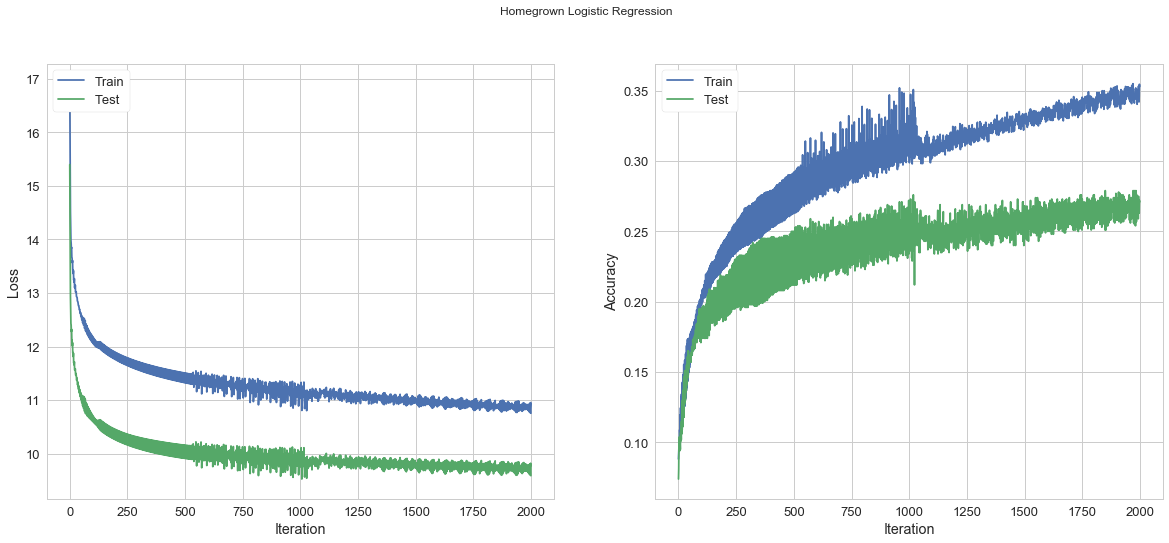

In [96]:
plt.figure(figsize=(20, 8))
plt.suptitle("Homegrown Logistic Regression")
plt.subplot(121)
plt.plot(model_lr_homegrown_fixed.history["cost"], label="Train")
plt.plot(model_lr_homegrown_fixed.history["val_cost"], label="Test")
plt.legend(loc="upper left")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.subplot(122)
plt.plot(model_lr_homegrown_fixed.history["acc"], label="Train")
plt.plot(model_lr_homegrown_fixed.history["val_acc"], label="Test")
plt.legend(loc="upper left")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

Prediction

In [97]:
y_pred_test = model_lr_homegrown_fixed.predict(X_test)

Accuracy

In [98]:
acc = accuracy_score(y_test, y_pred_test)
acc

0.26400000000000001

Keeping table of results up-to-date

In [104]:
results = pd.DataFrame(columns=["Model Description", "Test Accuracy"])
results.loc[len(results)] = ["LR Homegrown Fix 1", np.round(acc, 3)] #please update as needed
results

,Model Description,Test Accuracy
0,LR Homegrown Fix 1,0.264


## Let's improve by tuning training algo.
Look at the plots obtained at the end of task 1 (it fluctuates a lot). This behaviour is very common to stochastic gradient descent. But here we are using full GD.

In [105]:
#==================================================#
#               Place your code here               #
model_lr_homegrown_fixed.fit(X_train, y_train, max_iter=2000, alpha=0.0001, val_data=(X_test, y_test))
y_pred_test = model_lr_homegrown_fixed.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
print('accuracy: ', acc)

#==================================================#

accuracy:  0.313


In [106]:
results.loc[len(results)] = ["LR Homegrown Fix 2", np.round(acc, 3)] #please update as needed
results

,Model Description,Test Accuracy
0,LR Homegrown Fix 1,0.264
1,LR Homegrown Fix 2,0.313
